In [1]:
!pip3 install -I -r requirements.txt --quiet
!which python3
# Test hopsworks
try:
   import hopsworks
except ImportError:
   print()
   print("Hopsworks module not found!")

You should consider upgrading via the '/Users/filip/School/ID2223/lab1/lab1-environment/bin/python3.8 -m pip install --upgrade pip' command.
/Users/filip/School/ID2223/lab1/lab1-environment/bin/python3


# Load the traning data
Done locally from `./titanic.csv`

In [151]:
import pandas as pd

titanic_df = pd.read_csv("./titanic.csv")

# drop ticket and passenger id columns
titanic_df.drop(["Ticket", "PassengerId"], axis=1, inplace=True)

# convert sex to category
titanic_df["Sex"].astype("category")


0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: category
Categories (2, object): ['female', 'male']

# Get overview of data

In [ ]:
from IPython.core.interactiveshell import InteractiveShell

# Allow multiple outputs
InteractiveShell.ast_node_interactivity = "all"

### Check NaNs

In [ ]:
# Describe dataframe
titanic_df.describe()

# Check amount of NaNs
titanic_df.isnull().sum(axis = 0)

# Check NaNs in age
titanic_df.loc[titanic_df["Age"].isna()]

Take aways:

- Cabin has alot of NaNs, might need to drop
- Age has not as many NaNs, can resample them

### Check Name column

In [148]:
titanic_df["Name"]

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

Take aways:

- Every name has a title
- Might be able to use to resample missing ages

### Check some gut feelings

In [141]:
# titanic_df.loc[(titanic_df["Pclass"] == 3) & (titanic_df["Cabin"] == "G6")]
print("female survived")
len(titanic_df.loc[(titanic_df["Survived"] == 1) & (titanic_df["Sex"] == "female")])/len(titanic_df.loc[titanic_df["Sex"] == "female"])

print("child survived")
len(titanic_df.loc[(titanic_df["Survived"] == 1) & (titanic_df["Age"] <= 8 )])/len(titanic_df.loc[titanic_df["Age"] <= 8])

print("male survived")
len(titanic_df.loc[(titanic_df["Survived"] == 1) & (titanic_df["Sex"] == "male")])/len(titanic_df.loc[(titanic_df["Sex"] == "male")])


female survived


0.7420382165605095

child survived


0.6666666666666666

male survived


0.18890814558058924

### Plot survival distributions based on features

In [ ]:
import seaborn as sns
# distribution of survival based on age
survived = titanic_df["Survived"] == 1

# fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))

# distribution of age
sns.histplot(titanic_df['Age'], label="Age", color="blue",)

sns.histplot(titanic_df[~survived]['Age'], label="Not Survived", color="red")
sns.histplot(titanic_df[survived]['Age'], label="Survived", color="green")


### Correlation Matrix

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


<AxesSubplot: >

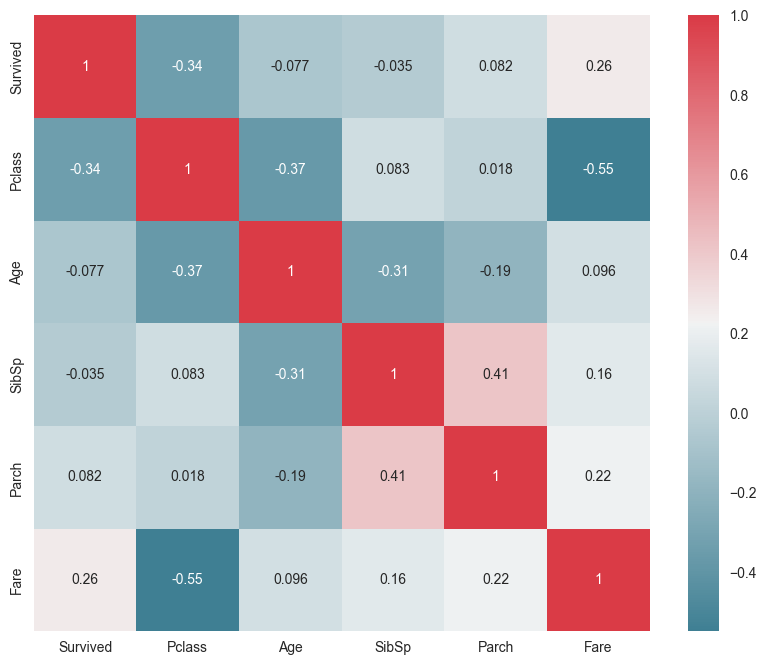

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

f, ax = plt.subplots(figsize=(10, 8))
corr = titanic_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

Take aways:

- Might be able to create a better feature for family on board

# Feature engineering

### Replace Name with corresponding title

In [214]:
if "Name" in titanic_df.columns:
    titanic_df["Title"] = titanic_df.Name.str.extract("([A-Za-z]+)\\.")
    titanic_df.drop("Name", axis=1, inplace=True)
titanic_df["Title"].unique()
titanic_df.head()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,NaN,S,Mr
1,1,1,female,38.0,1,0,71.2833,C85,C,Mrs
2,1,3,female,26.0,0,0,7.9250,NaN,S,Miss
3,1,1,female,35.0,1,0,53.1000,C123,S,Mrs
4,0,3,male,35.0,0,0,8.0500,NaN,S,Mr


## Resample missing ages from titles and ages

### Replace missing Mrs (men over 18)

In [221]:
# titanic_df.loc[(titanic_df["Title"] == "Mr") & titanic_df["Age"].isna()]
men_over_18_df = titanic_df.loc[(titanic_df["Title"] == "Mr") & titanic_df["Age"].notna() & (titanic_df["Age"] >= 18)]
men_over_18_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,NaN,S,Mr
4,0,3,male,35.0,0,0,8.0500,NaN,S,Mr
6,0,1,male,54.0,0,0,51.8625,E46,S,Mr
12,0,3,male,20.0,0,0,8.0500,NaN,S,Mr
13,0,3,male,39.0,1,5,31.2750,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...
881,0,3,male,33.0,0,0,7.8958,NaN,S,Mr
883,0,2,male,28.0,0,0,10.5000,NaN,S,Mr
884,0,3,male,25.0,0,0,7.0500,NaN,S,Mr
889,1,1,male,26.0,0,0,30.0000,C148,C,Mr


In [ ]:
import os
    
LOCAL=True

if LOCAL == False:
   stub = modal.Stub()
   image = modal.Image.debian_slim().pip_install(["hopsworks","joblib","seaborn","sklearn","dataframe-image"]) 

   @stub.function(image=image, schedule=modal.Period(days=1), secret=modal.Secret.from_name("jim-hopsworks-ai"))
   def f():
       g()

def g():
    import hopsworks
    import pandas as pd
    
    project = hopsworks.login()
    fs = project.get_feature_store()
    # iris_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/iris.csv")
    titanic_df = pd.read_csv("./titanic.csv")
    titanic_fg = fs.get_or_create_feature_group(
        name="iris_modal",
        version=1,
        primary_key=["sepal_length","sepal_width","petal_length","petal_width"], 
        description="Iris flower dataset")
    titanic_fg.insert(titanic_df, write_options={"wait_for_job" : False})

if __name__ == "__main__":
    if LOCAL == True :
        g()
    else:
        with stub.run():
            f()
